# Exercises Hand-In 3 e2
## Group 30 (Oliver Nilsson)

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import torch
from torch import cuda
import matplotlib.pyplot as plt
import re

# Print the versions of the libraries to check if they are installed correctly
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Re version: {re.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Pandas version: 2.2.2
Numpy version: 1.26.4
Sklearn version: 1.2.2
Re version: 2.2.1
Torch version: 2.1.2
Matplotlib version: 3.7.5


In [2]:
# Test if GPU is available
torch.cuda.get_device_name(0) if cuda.is_available() else "No GPU available"

'Tesla P100-PCIE-16GB'

In [3]:
# Install AugmentedSocialScientist to use Bert
!pip install AugmentedSocialScientist

# Clear output after install AugmentedSocialScientist
from IPython.display import clear_output
clear_output()

# Import and use Bert from AugmentedSocialScientist
from AugmentedSocialScientist.models import Bert

# Create an instance of Bert
bert = Bert()

There are 1 GPU(s) available.
We will use GPU 0: Tesla P100-PCIE-16GB


In [4]:
# Import csv file to a pandas dataframe
df_tweets = pd.read_csv('/kaggle/input/tweet-global-warming/1377884570_tweet_global_warming.csv', encoding='ISO-8859-1', engine='python')
df_tweets.dropna(inplace=True)  # Drop rows with missing values

# Replace Yes/Y with 1 and No/N with 0
df_tweets['existence'] = df_tweets['existence'].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0}).astype(int)

# Remove "[link]" from the tweets
df_tweets['tweet'] = df_tweets['tweet'].replace('\\[link\\]', '', regex=True)

# Display the first 5 rows of the dataframe to check if the data is loaded correctly
df_tweets.head()

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,1,1.0000
1,Fighting poverty and global warming in Africa,1,1.0000
2,Carbon offsets: How a Vatican forest failed to...,1,0.8786
3,Carbon offsets: How a Vatican forest failed to...,1,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,1,0.8087


In [5]:
# Split the data randomly into a test and a training set (70/30 % of the observations)
# Using random_state as seed for reproducibility
train_df, test_df = train_test_split(df_tweets, test_size=0.3, random_state=42)

# Display the first 5 rows of the dataframe to check if the data is loaded correctly
train_df.head()

,tweet,existence,existence.confidence
230,Ocean Saltiness Shows Global Warming Is Intens...,1,1.0000
498,RT @panteraonca07: Slideshow of Alaska Before ...,1,1.0000
2510,"@prismsinc Worlds Greenest Celebrity: Limos, P...",1,0.6499
5115,FRIDAY AFTERNOON IGNORANCE-OFF: Virginia GOP (...,1,0.6717
3370,RT @mmfa: Brain Freeze: Conservative media sti...,1,0.6969


## 2. Fine-tune a BERT model to predict non-climate sceptic language using the Augmented Social Scientist package

In [6]:
# Preprocess the data so it can be handled by the BERT model
train_dataloader = bert.encode(train_df['tweet'].values, train_df['existence'].values)

  0%|          | 0/2957 [00:00<?, ?it/s]

  0%|          | 0/2957 [00:00<?, ?it/s]

label ids: {0: 0, 1: 1}


In [7]:
test_dataloader = bert.encode(test_df['tweet'].values, test_df['existence'].values)

  0%|          | 0/1268 [00:00<?, ?it/s]

  0%|          | 0/1268 [00:00<?, ?it/s]

label ids: {0: 0, 1: 1}


The next step is to train the model using the training data. Various learning rates and numbers of epochs have been tested to optimize the model's performance. This thorough analysis aims to achieve the best possible Area Under the Curve (AUC), ensuring the model's predictive accuracy is maximized.

In [8]:
# Train the model
scores = bert.run_training(train_dataloader,
                           test_dataloader,
                           n_epochs=3,
                           lr=4e-5,
                           random_state=42,
                           save_model_as="climate_scepticism_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 3 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:10.
  Batch    80  of     93.    Elapsed: 0:00:20.

  Average training loss: 0.47
  Training took: 0:00:24

Running Validation...

  Average test loss: 0.40
  Validation took: 0:00:03
              precision    recall  f1-score   support

           0       0.72      0.43      0.53       327
           1       0.82      0.94      0.88       941

    accuracy                           0.81      1268
   macro avg       0.77      0.68      0.71      1268
weighted avg       0.80      0.81      0.79      1268


======== Epoch 2 / 3 ========
Training...
  Batch    40  of     93.    Elapsed: 0:00:10.
  Batch    80  of     93.    Elapsed: 0:00:20.

  Average training loss: 0.28
  Training took: 0:00:23

Running Validation...

  Average test loss: 0.47
  Validation took: 0:00:03
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       327
           1       0.86 

In [9]:
# Display the scores
scores

(array([0.69230769, 0.9       ]),
 array([0.71559633, 0.88947928]),
 array([0.7037594 , 0.89470871]),
 array([327, 941]))

In [10]:
# Predict using the trained model on the test data
pred_prob_test = bert.predict_with_model(test_dataloader, model_path="./models/climate_scepticism_model")

# Make the original existence column into an array
y = np.array(test_df['existence'])
fpr, tpr, thresholds = roc_curve(y, pred_prob_test[:, 1])

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/40 [00:00<?, ?it/s]

label ids: {0: 0, 1: 1}


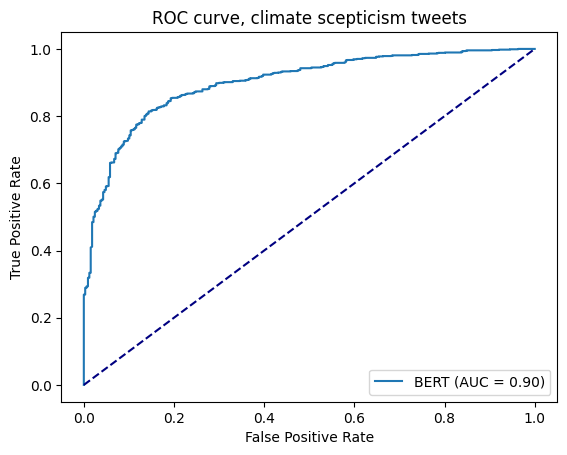

In [11]:
# Create the ROC graph
plt.figure()
plt.plot(fpr,tpr, label='BERT (AUC = %0.2f)' % roc_auc_score(y, pred_prob_test[:, 1]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, climate scepticism tweets')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Compute the AUC score
auc = roc_auc_score(y, pred_prob_test[:, 1])
print(f"AUC: {auc}")

AUC: 0.8994855495650083


An AUC (Area Under the Curve) of about 0.90 means the model is excellent at telling the difference between positive and negative cases. In simple terms, there's a 90% chance the model will rank a positive case higher than a negative one. This high AUC shows the model works very well overall.

To test the model further, we will use a custom tweet. The cutoff value is set at 0.75 because this is where the ROC curve flattens out, showing a good balance between sensitivity and specificity. This cutoff helps the model effectively tell positive and negative cases apart.

In [13]:
def predict_climate_scepticism(tweet, model_path="./models/climate_scepticism_model", cutoff=0.75):
    # Create a DataFrame with the tweet
    tweet_df = pd.DataFrame([tweet], columns=['tweet'])

    # Preprocess the data so it can be handled by the BERT model
    processed_tweet_df = bert.encode(tweet_df['tweet'])

    # Predict using the trained model
    pred_prob_tweet = bert.predict_with_model(processed_tweet_df, model_path=model_path)

    # Interpret the output and set limit. Set the cut-off to the specified threshold
    not_climate_sceptic = pred_prob_tweet[0, 1] > cutoff

    # Prepare the result message
    result_message = f"\nTweet: {tweet}\n"
    if not_climate_sceptic:
        result_message += f"Predicted probability of not being climate sceptic: {pred_prob_tweet[0, 1]:.2f}\n"
        result_message += "The tweet is not climate sceptic."
    else:
        result_message += f"Predicted probability of being climate sceptic: {pred_prob_tweet[0, 0]:.2f}\n"
        result_message += "The tweet is climate sceptic."

    return result_message

In [14]:
# Test tweets
tweets = ["Climate change is a hoax. The earth is not warming up. #climatechange #globalwarming #hoax",
          "The earth is warming up. We need to take action now. #climatechange #globalwarming #action",]

# Predict the climate scepticism of the test tweets
for tweet in tweets:
    print(predict_climate_scepticism(tweet))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

label ids: {0: 0, 1: 1}

Tweet: Climate change is a hoax. The earth is not warming up. #climatechange #globalwarming #hoax
Predicted probability of being climate sceptic: 0.96
The tweet is climate sceptic.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

label ids: {0: 0, 1: 1}

Tweet: The earth is warming up. We need to take action now. #climatechange #globalwarming #action
Predicted probability of not being climate sceptic: 0.98
The tweet is not climate sceptic.


The results show what the model thinks about two tweets. 

1. The first tweet says climate change isn't real, and the model is pretty sure (96%) it's climate sceptic.
2. The second tweet says the earth is warming and we need to do something. The model is quite sure (98%) it's not climate sceptic.

In simple terms, the model seems to understand whether tweets doubt climate change or not, and it's doing a good job at it.